In [1]:
# 1

import os
import cv2
import numpy as np
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import joblib
from tensorflow.keras.applications import VGG16
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import IsolationForest

from sklearn.ensemble import StackingClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.preprocessing import label_binarize

In [2]:
#2

# set crop size
# crop_size = 1900
# crop_size_2 = 720
# new_size = 224
crop_size_2 = 1600
new_size = 300


In [3]:
#3

# Define the path to the input folder containing images for training
input_folder = "C:/Users/Daxin Zhu/Desktop/code/11115079/train_multi"  

In [4]:
#4

image_files = [f for f in os.listdir(input_folder) if os.path.isfile(os.path.join(input_folder, f)) and f.lower().endswith(('.JPG', '.jpg', '.jpeg'))]


In [5]:
#5

# data and label for CNN MODEL TRAINING input
X = []  # data
y = []  # label

In [6]:
#6

# read each image file in the image_files list
for file_name in os.listdir(input_folder):
    if file_name.lower().endswith(('.jpg', '.jpeg', '.png')):
        image_path = os.path.join(input_folder, file_name)
        image = cv2.imread(image_path)
        if image is None:
            print(f"Unable to read image: {file_name}")
            continue
        height, width = image.shape[:2]
        if height < crop_size_2 or width < crop_size_2:
            print(f"Image {file_name} is smaller than the crop size. Skipping.")
            continue
        start_y = (height - crop_size_2) // 2
        start_x = (width - crop_size_2) // 2
        cropped_image = image[start_y:start_y + crop_size_2, start_x:start_x + crop_size_2]
        #cropped_image = cropped_image / 255.0
        #cropped_image = cv2.resize(cropped_image, (new_size, new_size))
        
        
        if file_name.split('.')[0].endswith('S'):
            label = 0  # clear
            
        elif file_name.split('.')[0].endswith('M'):
            label = 1  # motion blur
        elif file_name.split('.')[0].endswith('F'):
            label = 2  # defocused blur
        else:
            print(f"Unknown label for image {file_name}. Skipping.")
            continue

        cropped_image = cropped_image / 255.0
        cropped_image = cv2.resize(cropped_image, (new_size, new_size))
        X.append(cropped_image)
        y.append(label)

In [7]:
#7

# convert the X and y lists to numpy arrays
X = np.array(X).reshape(-1, new_size, new_size, 3)  
y = np.array(y)

print("Data preparation completed. Ready for CNN training.")

Data preparation completed. Ready for CNN training.


In [8]:
#8

# save the data and label arrays to the input folder
np.save(os.path.join(input_folder, 'X_data.npy'), X)
np.save(os.path.join(input_folder, 'y_labels.npy'), y)
print("Data preparation completed. Ready for CNN training.")

Data preparation completed. Ready for CNN training.


In [9]:
#9

input_data = X
input_labels = y

In [ ]:
#10



def novelty_detection(X, y):
  
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    clf_novelty = IsolationForest(
        contamination=0.03,   
        n_estimators=200,
        random_state=42
    )
    clf_novelty.fit(X_scaled)

    is_inlier = clf_novelty.predict(X_scaled)

    X_filled = X_scaled[is_inlier == 1]
    y_filled = y[is_inlier == 1]


    pca = PCA(n_components=2, random_state=42)
    X_pca = pca.fit_transform(X_scaled)

    plt.figure(figsize=(8, 6))
    plt.scatter(
        X_pca[is_inlier == 1, 0],
        X_pca[is_inlier == 1, 1],
        c='blue', label='Inlier (normal)'
    )
    plt.scatter(
        X_pca[is_inlier == -1, 0],
        X_pca[is_inlier == -1, 1],
        c='red', label='Outlier (anomaly)'
    )
    plt.title('Isolation Forest Novelty detection (PCA 2D)')
    plt.xlabel('main component 1')
    plt.ylabel('main component 2')
    plt.legend()
    plt.show()

    X_filled_original = scaler.inverse_transform(X_filled)

    return X_filled_original, y_filled

In [11]:
#11

num_samples_0 = input_data.shape[0]
flattened_size_0 = input_data.shape[1] * input_data.shape[2] * input_data.shape[3]  # 224 * 224 * 3
X_flattened_0 = input_data.reshape(num_samples_0, flattened_size_0)  # (300, 224*224*3)
print(X_flattened_0.shape)

(300, 270000)


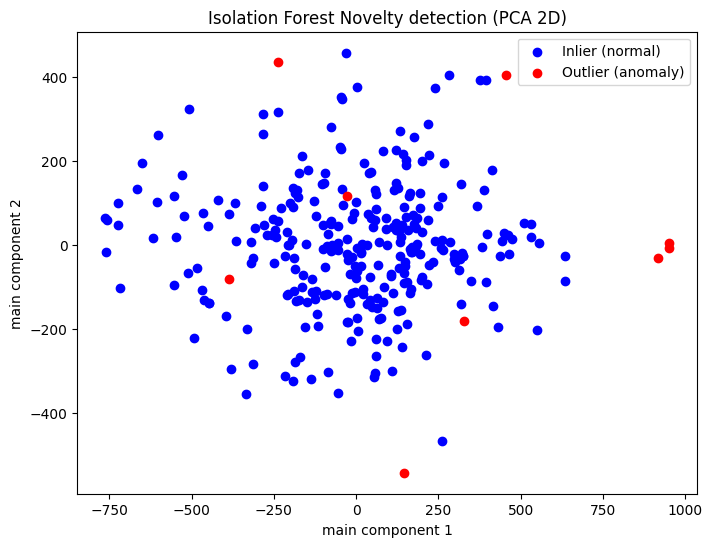

Restored shape: (291, 300, 300, 3)
Restored labels: (291,)


In [12]:
#12

test_data,test_labels = novelty_detection(X_flattened_0, input_labels)


num_samples = test_data.shape[0]

height, width, channels = 300, 300, 3  


input_data = test_data.reshape(num_samples, height, width, channels)
input_labels = test_labels

print("Restored shape:", input_data.shape)
print("Restored labels:", input_labels.shape)

In [13]:
#13

base_model = VGG16(weights='imagenet', include_top=False, input_shape=(300, 300, 3))


In [14]:
#14

x = base_model.output
x = Flatten()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(64, activation='relu', name='features')(x)
output = Dense(3, activation='softmax')(x) 


model = Model(inputs=base_model.input, outputs=output)
for layer in base_model.layers[-4:]:
    layer.trainable = True

optimizer = Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

Epoch 1/80
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10s/step - accuracy: 0.3709 - loss: 1.1941 
Epoch 1: val_accuracy improved from -inf to 0.59322, saving model to best_val_acc.keras

Epoch 1: val_loss improved from inf to 0.84435, saving model to best_val_loss.keras

Epoch 1: accuracy improved from -inf to 0.40517, saving model to best_model_acc.keras

Epoch 1: loss improved from inf to 1.13253, saving model to best_model_loss.keras
8/8 ━━━━━━━━━━━━━━━━━━━━ 101s 12s/step - accuracy: 0.3747 - loss: 1.1872 - val_accuracy: 0.5932 - val_loss: 0.8443
Epoch 2/80
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.4873 - loss: 0.9764 
Epoch 2: val_accuracy improved from 0.59322 to 0.64407, saving model to best_val_acc.keras

Epoch 2: val_loss improved from 0.84435 to 0.69110, saving model to best_val_loss.keras

Epoch 2: accuracy improved from 0.40517 to 0.51724, saving model to best_model_acc.keras

Epoch 2: loss improved from 1.13253 to 0.90722, saving model to best_model_loss.keras
8/8 ━━━━━━━━━━━━━━━━

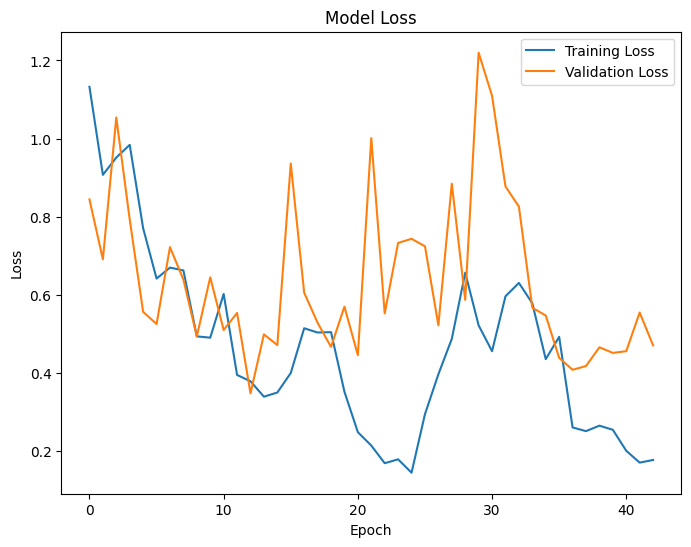

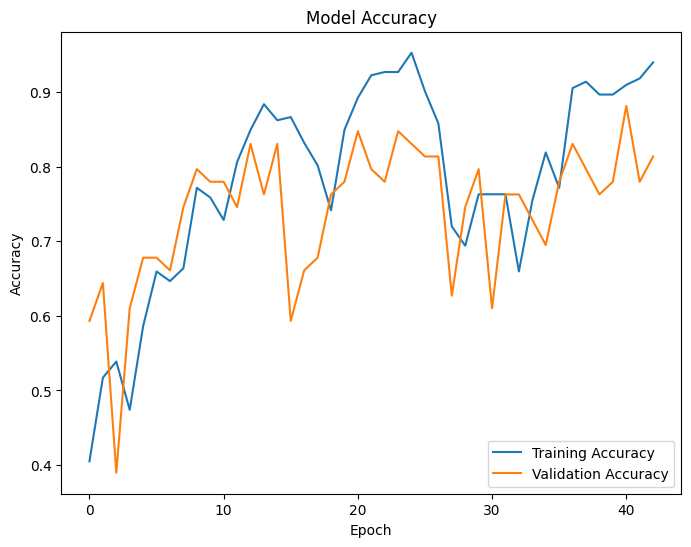

In [15]:
#15

input_train, input_val, labels_train, labels_val = train_test_split(input_data, input_labels, test_size=0.2, stratify=input_labels)


checkpoint_val_accuracy = ModelCheckpoint('best_val_acc.keras', monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)
checkpoint_val_loss = ModelCheckpoint('best_val_loss.keras', monitor='val_loss', save_best_only=True, mode='min', verbose=1)
checkpoint_accuracy = ModelCheckpoint('best_model_acc.keras', monitor='accuracy', save_best_only=True, mode='max', verbose=1)
checkpoint_loss = ModelCheckpoint('best_model_loss.keras', monitor='loss', save_best_only=True, mode='min', verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=30, verbose=1)

callbacks = [checkpoint_val_accuracy, checkpoint_val_loss, checkpoint_accuracy, checkpoint_loss, early_stopping]


history = model.fit(
    input_train, labels_train, 
    epochs=80, 
    batch_size=32, 
    validation_data=(input_val, labels_val), 
    callbacks=callbacks
)



plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.show()

plt.figure(figsize=(8, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

In [17]:
#16

# Define the path to the test folder containing images for testing
test_folder = "C:/Users/Daxin Zhu/Desktop/code/11115079/test_bright"

X_test = []
y_test = []

In [18]:
#17


for file_name in os.listdir(test_folder):
    if file_name.lower().endswith(('.jpg', '.jpeg', '.png')):
        image_path = os.path.join(test_folder, file_name)
        image = cv2.imread(image_path)
        if image is None:
            print(f"Unable to read image: {file_name}")
            continue
        height, width = image.shape[:2]
        if height < crop_size_2 or width < crop_size_2:
            print(f"Image {file_name} is smaller than the crop size. Skipping.")
            continue
        start_y = (height - crop_size_2) // 2
        start_x = (width - crop_size_2) // 2
        cropped_image = image[start_y:start_y + crop_size_2, start_x:start_x + crop_size_2]
        
        if file_name.split('.')[0].endswith('S'):
            label = 0  # clear
        elif file_name.split('.')[0].endswith('M'):
            label = 1  # motion blur
        elif file_name.split('.')[0].endswith('F'):
            label = 2  # defocused blur
        else:
            print(f"Unknown label for image {file_name}. Skipping.")
            continue

        cropped_image = cropped_image / 255.0
        cropped_image = cv2.resize(cropped_image, (new_size, new_size))
        X_test.append(cropped_image)
        y_test.append(label)

In [19]:
#18

# convert the X and y lists to numpy arrays
X_test = np.array(X_test).reshape(-1, new_size, new_size, 3)  
y_test = np.array(y_test)

In [ ]:
#19

# print the shape of the data and label
print("Data shape:", X_test.shape)
print("Label shape:", y_test.shape)

Data shape: (300, 300, 300, 3)
Label shape: (300,)


In [ ]:
#20

def evaluate_and_visualize(model, X_test, y_test):
    
    
    loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
    print(f"Loss: {loss:.4f}, Accuracy: {accuracy*100:.2f}%")
    
    
    y_pred_proba = model.predict(X_test)  
    y_pred = np.argmax(y_pred_proba, axis=1)
    y_true = y_test.flatten()
    
    
    cm = confusion_matrix(y_test, y_pred)
    print("Confusion Matrix:")
    print(cm)

    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Clear', 'Motion', 'Defocused'],
                yticklabels=['Clear', 'Motion', 'Defocused'])
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()

    print("Classification Report:")
    print(classification_report(
        y_test,
        y_pred,
        target_names=['Clear', 'Motion', 'Defocused']
    ))
    
    
    
    n_classes = 3
    y_test_bin = label_binarize(y_true, classes=[0, 1, 2])
    
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_proba[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    plt.figure(figsize=(8, 6))
    colors = ['aqua', 'darkorange', 'cornflowerblue']
    labels = ['Clear', 'Motion', 'Defocused']

    for i, color in enumerate(colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                label=f'{labels[i]} (AUC = {roc_auc[i]:.2f})')

    plt.plot([0,1], [0,1], 'k--', lw=2)
    plt.xlim([0.0,1.0])
    plt.ylim([0.0,1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve for Three-Class Model')
    plt.legend(loc='lower right')
    plt.show()

Loss: 0.8050, Accuracy: 85.67%
10/10 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step
Confusion Matrix:
[[99  1  0]
 [ 2 65 33]
 [ 1  6 93]]


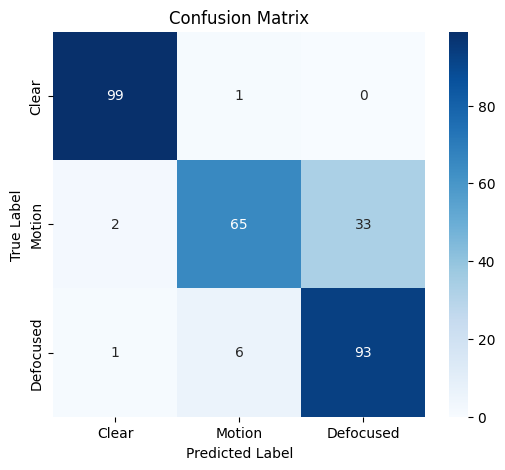

Classification Report:
              precision    recall  f1-score   support

       Clear       0.97      0.99      0.98       100
      Motion       0.90      0.65      0.76       100
   Defocused       0.74      0.93      0.82       100

    accuracy                           0.86       300
   macro avg       0.87      0.86      0.85       300
weighted avg       0.87      0.86      0.85       300



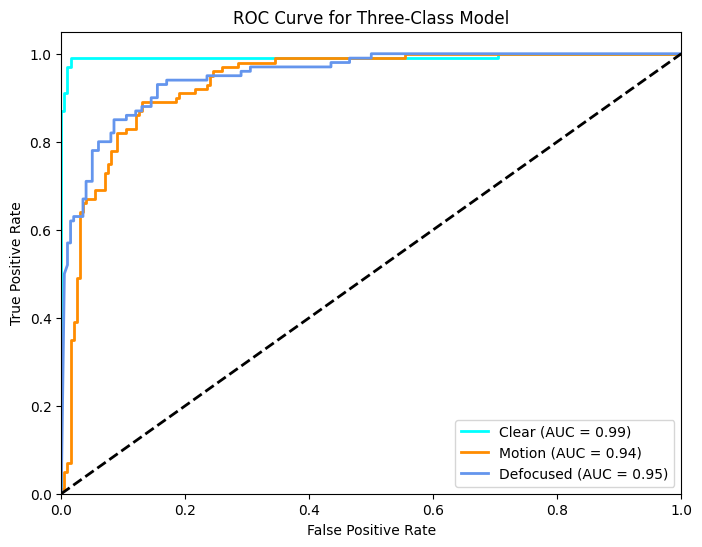

Loss: 0.8050, Accuracy: 85.67%
10/10 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step
Confusion Matrix:
[[99  1  0]
 [ 2 65 33]
 [ 1  6 93]]


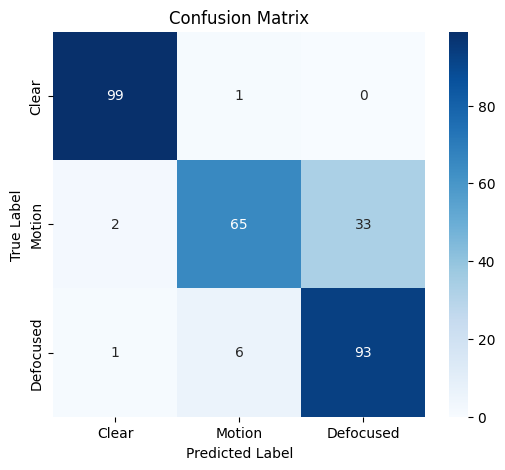

Classification Report:
              precision    recall  f1-score   support

       Clear       0.97      0.99      0.98       100
      Motion       0.90      0.65      0.76       100
   Defocused       0.74      0.93      0.82       100

    accuracy                           0.86       300
   macro avg       0.87      0.86      0.85       300
weighted avg       0.87      0.86      0.85       300



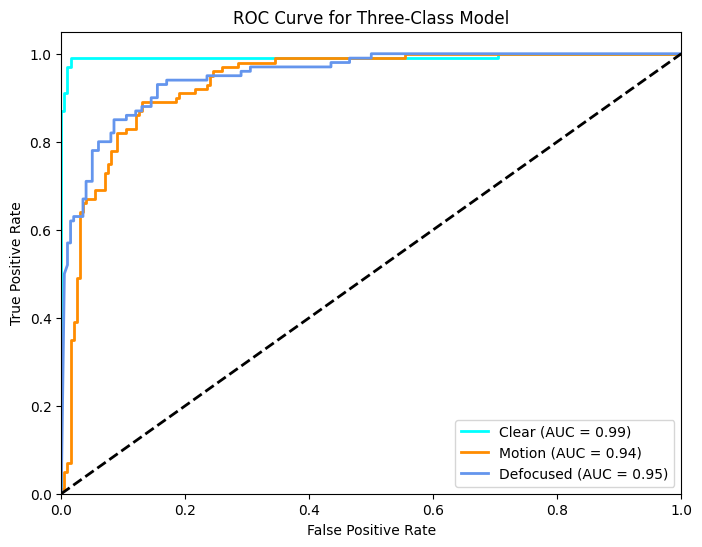

Loss: 0.3775, Accuracy: 90.00%
10/10 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step
Confusion Matrix:
[[100   0   0]
 [  9  75  16]
 [  1   4  95]]


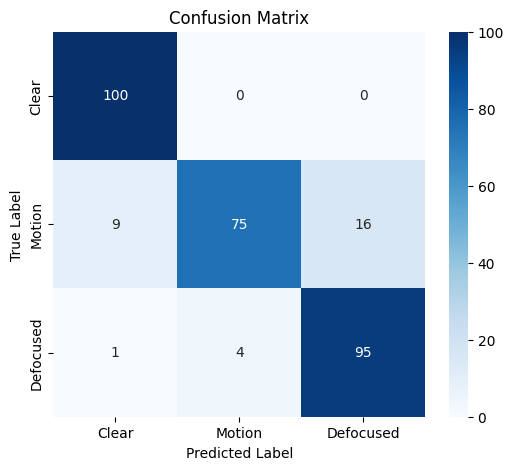

Classification Report:
              precision    recall  f1-score   support

       Clear       0.91      1.00      0.95       100
      Motion       0.95      0.75      0.84       100
   Defocused       0.86      0.95      0.90       100

    accuracy                           0.90       300
   macro avg       0.90      0.90      0.90       300
weighted avg       0.90      0.90      0.90       300



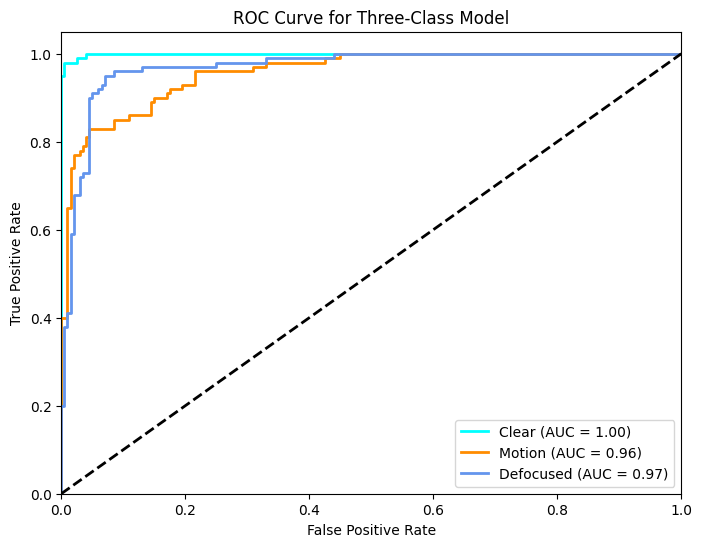

Loss: 0.4056, Accuracy: 78.67%
10/10 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step
Confusion Matrix:
[[90 10  0]
 [ 2 96  2]
 [ 1 49 50]]


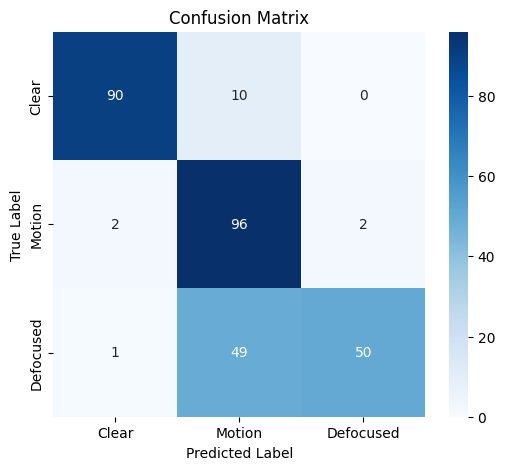

Classification Report:
              precision    recall  f1-score   support

       Clear       0.97      0.90      0.93       100
      Motion       0.62      0.96      0.75       100
   Defocused       0.96      0.50      0.66       100

    accuracy                           0.79       300
   macro avg       0.85      0.79      0.78       300
weighted avg       0.85      0.79      0.78       300



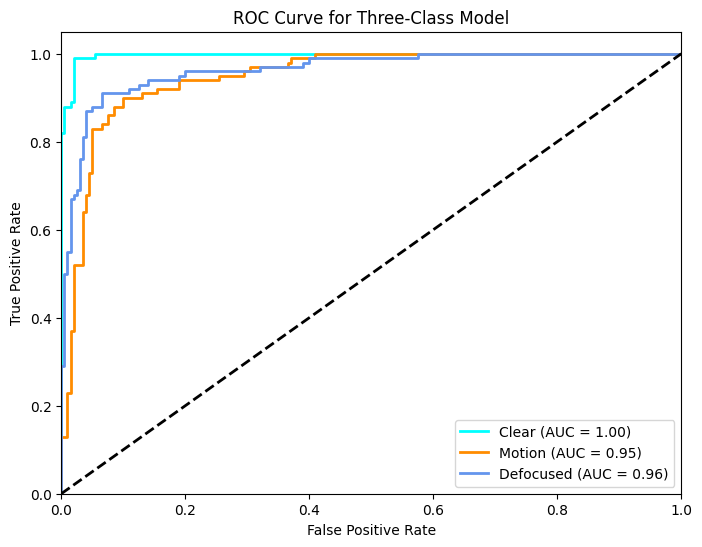

In [ ]:
#21

# visualize the model performance on the test set using the best model weights
#  best_model_acc.keras
model.load_weights('best_model_acc.keras')
evaluate_and_visualize(model, X_test, y_test)

#  best_model_loss.keras
model.load_weights('best_model_loss.keras')
evaluate_and_visualize(model, X_test, y_test)

#  best_val_acc.keras
model.load_weights('best_val_acc.keras')
evaluate_and_visualize(model, X_test, y_test)

#  best_val_loss.keras
model.load_weights('best_val_loss.keras')
evaluate_and_visualize(model, X_test, y_test)

In [ ]:
#22

# best model for feature extraction

model.load_weights('best_val_acc.keras')
# model.load_weights('best_val_loss.keras')
feature_extractor = Model(inputs=model.input, outputs=model.get_layer('features').output)
test_features = feature_extractor.predict(X_test)
train_features = feature_extractor.predict(input_data)
print(test_features.shape)
print(train_features.shape)


10/10 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step
(300, 64)
(291, 64)


Accuracy: 89.67%
Confusion Matrix:
[[96  4  0]
 [ 6 82 12]
 [ 0  9 91]]


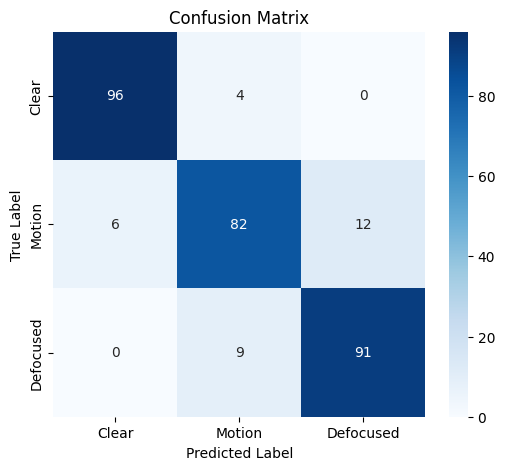

Classification Report:
              precision    recall  f1-score   support

       Clear       0.94      0.96      0.95       100
      Motion       0.86      0.82      0.84       100
   Defocused       0.88      0.91      0.90       100

    accuracy                           0.90       300
   macro avg       0.90      0.90      0.90       300
weighted avg       0.90      0.90      0.90       300



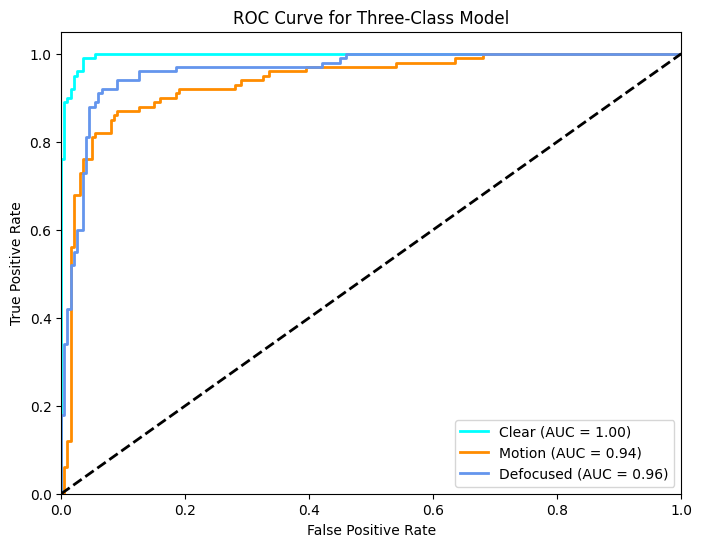

In [ ]:
#23

scaler = StandardScaler()
X_train = scaler.fit_transform(train_features)
X_test = scaler.transform(test_features)


svm_classifier = SVC(kernel='linear', C=1.0, gamma='scale', probability=True)
svm_classifier.fit(X_train, input_labels)  


y_pred = svm_classifier.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)  
print(f"Accuracy: {accuracy * 100:.2f}%")


cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Clear', 'Motion', 'Defocused'],
            yticklabels=['Clear', 'Motion', 'Defocused'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=['Clear', 'Motion', 'Defocused']))


n_classes = 3
y_true_bin = label_binarize(y_test, classes=[0, 1, 2])


y_pred_proba = svm_classifier.predict_proba(X_test)  # shape: (n_samples, 4)

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])


plt.figure(figsize=(8, 6))
colors = ['aqua', 'darkorange', 'cornflowerblue']
labels = ['Clear', 'Motion', 'Defocused']

for i, color in enumerate(colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
            label=f'{labels[i]} (AUC = {roc_auc[i]:.2f})')

plt.plot([0,1], [0,1], 'k--', lw=2)
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Three-Class Model')
plt.legend(loc='lower right')
plt.show()

这里往下都是ensemble

In [ ]:
#24

# Base models
svm_model = SVC(kernel='linear', C=1, probability=True, random_state=42)
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
logistic_model = LogisticRegression(random_state=42)

In [ ]:
#25

# Stacking Classifier with Logistic Regression as final estimator
stacking_clf = StackingClassifier(
    estimators=[
        ('svm', svm_model),
        ('rf', rf_model),
        ('log_reg', logistic_model)
    ],
    final_estimator=LogisticRegression(),
    passthrough=True,  # Pass original features along with predictions to the final estimator
    n_jobs=-1
)

In [ ]:
#26

# Train the stacking classifier
stacking_clf.fit(X_train, input_labels)

StackingClassifier(estimators=[('svm',
                                SVC(C=1, kernel='linear', probability=True,
                                    random_state=42)),
                               ('rf', RandomForestClassifier(random_state=42)),
                               ('log_reg',
                                LogisticRegression(random_state=42))],
                   final_estimator=LogisticRegression(), n_jobs=-1,
                   passthrough=True)

In [ ]:
#27

# Predict
y_pred_stack = stacking_clf.predict(X_test)

In [ ]:
#28

# Calculate accuracy
accuracy_stack = accuracy_score(y_test, y_pred_stack)
print(f"Stacking Classifier Accuracy: {accuracy_stack * 100:.2f}%")

Stacking Classifier Accuracy: 91.33%


In [ ]:
#29

# Optionally, use Voting Classifier for weighted ensemble
voting_clf = VotingClassifier(
    estimators=[('svm', svm_model), ('rf', rf_model), ('log_reg', logistic_model)],
    voting='soft',  # Use soft voting for probability-based weighting
    weights=[2, 3, 1],  # Assigning different weights to the models
    n_jobs=-1
)

In [ ]:
#30

# Train the voting classifier
voting_clf.fit(X_train, input_labels)

VotingClassifier(estimators=[('svm',
                              SVC(C=1, kernel='linear', probability=True,
                                  random_state=42)),
                             ('rf', RandomForestClassifier(random_state=42)),
                             ('log_reg', LogisticRegression(random_state=42))],
                 n_jobs=-1, voting='soft', weights=[2, 3, 1])

In [ ]:
#31

# Predict
y_pred_vote = voting_clf.predict(X_test)

In [ ]:
#32

# Calculate accuracy
accuracy_vote = accuracy_score(y_test, y_pred_vote)
print(f"Voting Classifier Accuracy: {accuracy_vote * 100:.2f}%")

Voting Classifier Accuracy: 91.33%
